In [17]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"GPU: {device}")


GPU: cuda


In [18]:
import time

start_time_code = time.time()

## Import Library

In [19]:
# import stanza
# stanza.download('id')


In [20]:
import pandas as pd
import numpy as np
import nltk, re, string

from sklearn import naive_bayes

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report,ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn

from nlp_id.lemmatizer import Lemmatizer

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from wordcloud import WordCloud

import joblib

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline


# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('tokenize')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt_tab')

In [21]:
data = pd.read_csv('DataTweetFix - Copy (2) - Copy.csv')

display(data)

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1.760000e+18,Thu Feb 15 14:45:30 +0000 2024,7,Caleg Sistem Paylater Yang Penting DP Dulu... ...,1.760000e+18,https://pbs.twimg.com/media/GGYrc6ubYAAJa8w.jpg,NaN,in,"DKI Jakarta, Indonesia",2,2,2,https://x.com/AchmadAnnama/status/175814048325...,1.196081e+08,AchmadAnnama
1,1.760000e+18,Thu Feb 15 14:51:22 +0000 2024,94,Anies menegaskan misi yang besar itu ialah mem...,1.760000e+18,https://pbs.twimg.com/ext_tw_video_thumb/17581...,NaN,in,"Jakarta, Indonesia",1,5,23,https://x.com/republikaonline/status/175814195...,2.212690e+07,republikaonline
2,1.760000e+18,Thu Feb 15 12:00:02 +0000 2024,0,Link dan cara cek real count pemilu 2024 resmi...,1.760000e+18,https://pbs.twimg.com/amplify_video_thumb/1758...,NaN,in,"Jakarta Capital Region, Indone",0,0,0,https://x.com/medcom_id/status/175809884275753...,9.030000e+17,medcom_id
3,1.760000e+18,Thu Feb 15 13:00:02 +0000 2024,0,Investasinya selama ini gimana nih Pak Hary Ta...,1.760000e+18,https://pbs.twimg.com/media/GGXRfTVakAAzrXr.jpg,NaN,in,"Jakarta, Indonesia",0,1,0,https://x.com/pinterpolitik/status/17581139412...,7.990000e+17,pinterpolitik
4,1.760000e+18,Thu Feb 15 13:00:01 +0000 2024,0,KPU sebut 668 TPS berpotensi melakukan pemungu...,1.760000e+18,https://pbs.twimg.com/amplify_video_thumb/1758...,NaN,in,"Jakarta Capital Region, Indone",0,0,1,https://x.com/medcom_id/status/175811393662737...,9.030000e+17,medcom_id
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17866,1.767790e+18,Wed Mar 13 05:46:41 +0000 2024,1,Perolehan suara caleg petahana DPD itu lebih t...,1.767790e+18,NaN,NaN,in,Aceh,0,0,0,https://x.com/serambinews/status/1767789356910...,6.463565e+07,serambinews
17867,1.767790e+18,Wed Mar 13 05:46:00 +0000 2024,0,#zonauang #zonajajan #infoloker #lokerwfh info...,1.767790e+18,NaN,NaN,in,she/her,0,0,0,https://x.com/idolletes/status/176778918462475...,7.347410e+17,idolletes
17868,1.767790e+18,Wed Mar 13 05:44:43 +0000 2024,0,ga heran sih soalnya capres yg paling banyak d...,1.767790e+18,NaN,NaN,in,pinnedÂ©ann,0,2,0,https://x.com/rentrouvaile/status/176778886261...,1.489664e+09,rentrouvaile
17869,1.767510e+18,Wed Mar 13 05:44:07 +0000 2024,0,@axdwin Ehemmm ï¸ https://t.co/Ada0zVFB5D,1.767790e+18,https://pbs.twimg.com/media/GIhydTOaEAAaiot.jpg,axdwin,pl,"Yogyakarta, Indonesia",0,1,0,https://x.com/tukangsetrum_/status/17677887131...,1.323220e+18,tukangsetrum_


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17871 entries, 0 to 17870
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   conversation_id_str      17871 non-null  float64
 1   created_at               17871 non-null  object 
 2   favorite_count           17871 non-null  int64  
 3   full_text                17868 non-null  object 
 4   id_str                   17871 non-null  float64
 5   image_url                6043 non-null   object 
 6   in_reply_to_screen_name  6413 non-null   object 
 7   lang                     17871 non-null  object 
 8   location                 10534 non-null  object 
 9   quote_count              17871 non-null  int64  
 10  reply_count              17871 non-null  int64  
 11  retweet_count            17871 non-null  int64  
 12  tweet_url                17871 non-null  object 
 13  user_id_str              17871 non-null  float64
 14  username              

In [23]:
data.shape

(17871, 15)

In [24]:
data.isnull().sum()

conversation_id_str            0
created_at                     0
favorite_count                 0
full_text                      3
id_str                         0
image_url                  11828
in_reply_to_screen_name    11458
lang                           0
location                    7337
quote_count                    0
reply_count                    0
retweet_count                  0
tweet_url                      0
user_id_str                    0
username                       0
dtype: int64

In [25]:
data.duplicated().sum()

1104

## Data Cleansing

In [26]:
data = data.drop_duplicates()

In [27]:
data = data[data['lang'] == 'in']

In [28]:
data['full_text'] = data['full_text'].str.lower()

In [29]:
data = data[['created_at', 'username', 'full_text']]

In [30]:
data_slang = pd.read_csv('kamus-alay/colloquial-indonesian-lexicon1.csv')

def replace_slang(text):
    words = text.split()
    for i in range(len(words)):
        slang_word = data_slang[data_slang['slang'] == words[i]]
        if not slang_word.empty:
            words[i] = slang_word['formal'].values[0]
    return ' '.join(words)

In [31]:
data['full_text'] = data['full_text'].apply(replace_slang)

In [32]:
def remove_tweet_special(text):
    # Menghapus tab, baris baru, dan back slice
    text = text.replace('\\t', ' ').replace('\\n', ' ').replace('\\u', ' ').replace('\\', '')

    # Menghapus karakter non-ASCII (emotikon, huruf Cina, dll.)
    text = ''.join(char for char in text if ord(char) < 128)

    # Menghapus mention, link, dan hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())

    # Menghapus URL yang tidak lengkap
    text = text.replace("http://", " ").replace("https://", " ")

    return text

def clean_text(data):
    # Menghapus karakter yang tidak diinginkan (_) dan karakter selain huruf
    data['full_text'] = data['full_text'].str.replace(r"[^a-zA-Z ]+", " ").str.strip()

    # Mengganti multiple whitespace dengan single whitespace
    data['full_text'] = data['full_text'].replace(" +", " ", regex=True)

    return data

def clean_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_numbers(text):
    return re.sub('[0-9]+', '', text)

data['full_text'] = data['full_text'].apply(remove_tweet_special)
data['full_text'] = data['full_text'].apply(remove_numbers)
data['full_text'] = data['full_text'].apply(clean_punctuation)
data = clean_text(data)


<>:9: SyntaxWarning: invalid escape sequence '\w'
<>:9: SyntaxWarning: invalid escape sequence '\w'
C:\Users\asus.LAPTOP-P9TBK6TS.000\AppData\Local\Temp\ipykernel_6068\511283437.py:9: SyntaxWarning: invalid escape sequence '\w'
  text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", text).split())


In [33]:
data.head()

,created_at,username,full_text
0,Thu Feb 15 14:45:30 +0000 2024,AchmadAnnama,caleg sistem paylater yang penting dp dulu heh...
1,Thu Feb 15 14:51:22 +0000 2024,republikaonline,anies menegaskan misi yang besar itu ialah mem...
2,Thu Feb 15 12:00:02 +0000 2024,medcom_id,link dan cara cek real count pemilu resmi kpu
3,Thu Feb 15 13:00:02 +0000 2024,pinterpolitik,investasinya selama ini bagaimana nih pak hary...
4,Thu Feb 15 13:00:01 +0000 2024,medcom_id,kpu sebut tps berpotensi melakukan pemungutan ...


In [34]:
all_tweets = ' '.join(data['full_text'])

# Mencetak beberapa karakter pertama untuk memverifikasi
print("Gabungan tweet (200 karakter pertama):")
print(all_tweets[:200])

# Mencetak total jumlah karakter
print(f"\nTotal jumlah karakter: {len(all_tweets)}")

# Mencetak jumlah kata unik
unique_words = set(all_tweets.split())
print(f"Jumlah kata unik: {len(unique_words)}")

Gabungan tweet (200 karakter pertama):
caleg sistem paylater yang penting dp dulu hehehehe anies menegaskan misi yang besar itu ialah membangun demokrasi di indonesia yang menjunjung tinggi etika dan adab serta demokrasi yang memberikan ru

Total jumlah karakter: 2194211
Jumlah kata unik: 22525


## Labelling Data

### IndoBERT Classification

In [35]:
# from transformers import pipeline

# start_time_class = time.time()

# pretrained = "mdhugol/indonesia-bert-sentiment-classification"
# model = AutoModelForSequenceClassification.from_pretrained(pretrained)
# tokenizer = AutoTokenizer.from_pretrained(pretrained)
# sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# # Mapping label
# label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}


# # Fungsi untuk menganalisis sentimen
# def analyze_sentiment(text):
#     result = sentiment_analysis(text)[0]
#     label = label_index.get(result['label'], 'unknown')
#     score = result['score']
#     return label, score

# # Terapkan fungsi ke DataFrame dan tambahkan kolom baru
# data[['indoBert Classification', 'indoBERT Classification score']] = data['full_text'].apply(analyze_sentiment).apply(pd.Series)

# # Tampilkan DataFrame dengan kolom baru
# data.head()

# end_time = time.time()

# execution_time = end_time - start_time_class
# print(f"Waktu eksekusi: {execution_time} detik")

In [36]:
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import time
import pandas as pd

# Periksa ketersediaan CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Fungsi untuk memeriksa penggunaan memori GPU
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved()/1e9:.2f} GB")

start_time_class = time.time()

pretrained = "mdhugol/indonesia-bert-sentiment-classification"
model = AutoModelForSequenceClassification.from_pretrained(pretrained).to(device)
tokenizer = AutoTokenizer.from_pretrained(pretrained)

# Explicitly set the device when creating the pipeline
sentiment_analysis = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)

# Verifikasi lokasi model
print(f"Model is on: {next(model.parameters()).device}")

# Verifikasi pipeline menggunakan GPU
print(f"Pipeline is using: {'GPU' if sentiment_analysis.device.type == 'cuda' else 'CPU'}")

# Mapping label
label_index = {'LABEL_0': 'positive', 'LABEL_1': 'neutral', 'LABEL_2': 'negative'}

# Fungsi untuk menganalisis sentimen
def analyze_sentiment(text):
    result = sentiment_analysis(text)[0]
    label = label_index.get(result['label'], 'unknown')
    score = result['score']
    return label, score

# Terapkan fungsi ke DataFrame dan tambahkan kolom baru
data[['indoBert Classification', 'indoBERT Classification score']] = data['full_text'].apply(analyze_sentiment).apply(pd.Series)

# Tampilkan DataFrame dengan kolom baru
print(data.head())

end_time = time.time()

execution_time = end_time - start_time_class
print(f"Waktu eksekusi: {execution_time} detik")

# Periksa penggunaan memori GPU setelah eksekusi
print_gpu_memory()

# Bersihkan cache CUDA jika diperlukan
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("CUDA cache telah dibersihkan.")

Using device: cuda


c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\envs\skripsi-fix\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Model is on: cuda:0
Pipeline is using: GPU


c:\Users\asus.LAPTOP-P9TBK6TS.000\anaconda3\envs\skripsi-fix\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


                       created_at         username  \
0  Thu Feb 15 14:45:30 +0000 2024     AchmadAnnama   
1  Thu Feb 15 14:51:22 +0000 2024  republikaonline   
2  Thu Feb 15 12:00:02 +0000 2024        medcom_id   
3  Thu Feb 15 13:00:02 +0000 2024    pinterpolitik   
4  Thu Feb 15 13:00:01 +0000 2024        medcom_id   

                                           full_text indoBert Classification  \
0  caleg sistem paylater yang penting dp dulu heh...                 neutral   
1  anies menegaskan misi yang besar itu ialah mem...                 neutral   
2      link dan cara cek real count pemilu resmi kpu                 neutral   
3  investasinya selama ini bagaimana nih pak hary...                 neutral   
4  kpu sebut tps berpotensi melakukan pemungutan ...                 neutral   

   indoBERT Classification score  
0                       0.689250  
1                       0.876838  
2                       0.997821  
3                       0.864559  
4                  

In [37]:
data.head()

,created_at,username,full_text,indoBert Classification,indoBERT Classification score
0,Thu Feb 15 14:45:30 +0000 2024,AchmadAnnama,caleg sistem paylater yang penting dp dulu heh...,neutral,0.689250
1,Thu Feb 15 14:51:22 +0000 2024,republikaonline,anies menegaskan misi yang besar itu ialah mem...,neutral,0.876838
2,Thu Feb 15 12:00:02 +0000 2024,medcom_id,link dan cara cek real count pemilu resmi kpu,neutral,0.997821
3,Thu Feb 15 13:00:02 +0000 2024,pinterpolitik,investasinya selama ini bagaimana nih pak hary...,neutral,0.864559
4,Thu Feb 15 13:00:01 +0000 2024,medcom_id,kpu sebut tps berpotensi melakukan pemungutan ...,neutral,0.997546


In [38]:
target_columns = [
     'indoBert Classification'
]

data[target_columns] = data[target_columns].apply(lambda x: x.str.lower())

def normalize_sentiment(value):
    value = value.lower()

    if value in ['negative', 'negatif']:
        return 'negatif'

    elif value in ['positive', 'positif']:
        return 'positif'

    elif value in ['neutral', 'netral']:
        return 'netral'

    return value

# Lakukan normalisasi pada setiap kolom target
for target_col in target_columns:
    data[target_col] = data[target_col].apply(normalize_sentiment)

In [39]:
data.head()

,created_at,username,full_text,indoBert Classification,indoBERT Classification score
0,Thu Feb 15 14:45:30 +0000 2024,AchmadAnnama,caleg sistem paylater yang penting dp dulu heh...,netral,0.689250
1,Thu Feb 15 14:51:22 +0000 2024,republikaonline,anies menegaskan misi yang besar itu ialah mem...,netral,0.876838
2,Thu Feb 15 12:00:02 +0000 2024,medcom_id,link dan cara cek real count pemilu resmi kpu,netral,0.997821
3,Thu Feb 15 13:00:02 +0000 2024,pinterpolitik,investasinya selama ini bagaimana nih pak hary...,netral,0.864559
4,Thu Feb 15 13:00:01 +0000 2024,medcom_id,kpu sebut tps berpotensi melakukan pemungutan ...,netral,0.997546


In [58]:
data.to_csv('labellings sentiment.csv', index=False)

## Data Pre-Processing

In [41]:
lemmatizer = Lemmatizer()

def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

# nlp = stanza.Pipeline('id')

# def lemmatize_text(text):
#     doc = nlp(text)  # Proses teks menggunakan Stanza
#     lemmatized_text = " ".join([word.lemma for sentence in doc.sentences for word in sentence.words])
#     return lemmatized_text

# # Terapkan fungsi lemmatize_text ke setiap baris di kolom 'full_text'
# data['lemmatized_text'] = data['full_text'].apply(lemmatize_text)

# # Menampilkan hasil lemmatization
# print(data[['full_text', 'lemmatized_text']])


def remove_stopwords(text):
    stop_words = set(stopwords.words('indonesian'))
    return ' '.join([word for word in nltk.word_tokenize(text) if word.lower() not in stop_words])


data['full_text'] = data['full_text'].apply(lemmatize_text)

data['full_text'] = data['full_text'].apply(remove_stopwords)

In [42]:
data.dropna(inplace=True)

In [43]:
data.head()

,created_at,username,full_text,indoBert Classification,indoBERT Classification score
0,Thu Feb 15 14:45:30 +0000 2024,AchmadAnnama,caleg sistem paylater dp hehehehe,netral,0.689250
1,Thu Feb 15 14:51:22 +0000 2024,republikaonline,anies misi bangun demokrasi indonesia junjung ...,netral,0.876838
2,Thu Feb 15 12:00:02 +0000 2024,medcom_id,link cek real count milu resmi kpu,netral,0.997821
3,Thu Feb 15 13:00:02 +0000 2024,pinterpolitik,investasi nih hary tanoe,netral,0.864559
4,Thu Feb 15 13:00:01 +0000 2024,medcom_id,kpu tps potensi laku pungut suara susul,netral,0.997546


## Visualisasi Data

In [44]:
all_tweets_clean = ' '.join(data['full_text'])

# Mencetak beberapa karakter pertama untuk memverifikasi
print("Gabungan tweet (200 karakter pertama):")
print(all_tweets_clean[:200])

# Mencetak total jumlah karakter
print(f"\nTotal jumlah karakter: {len(all_tweets_clean)}")

# Mencetak jumlah kata unik
unique_words = set(all_tweets_clean.split())
print(f"Jumlah kata unik: {len(unique_words)}")

Gabungan tweet (200 karakter pertama):
caleg sistem paylater dp hehehehe anies misi bangun demokrasi indonesia junjung etika adab demokrasi ruang hormat gagas ide dialog berita lengkap baca link cek real count milu resmi kpu investasi nih 

Total jumlah karakter: 1370155
Jumlah kata unik: 16635


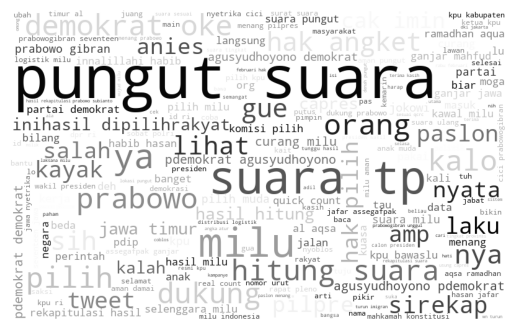

In [45]:
wc = WordCloud(background_color='white', colormap = 'binary',
     stopwords = ['meta'], width = 800, height = 500).generate(all_tweets_clean)
plt.axis("off")
plt.imshow(wc)

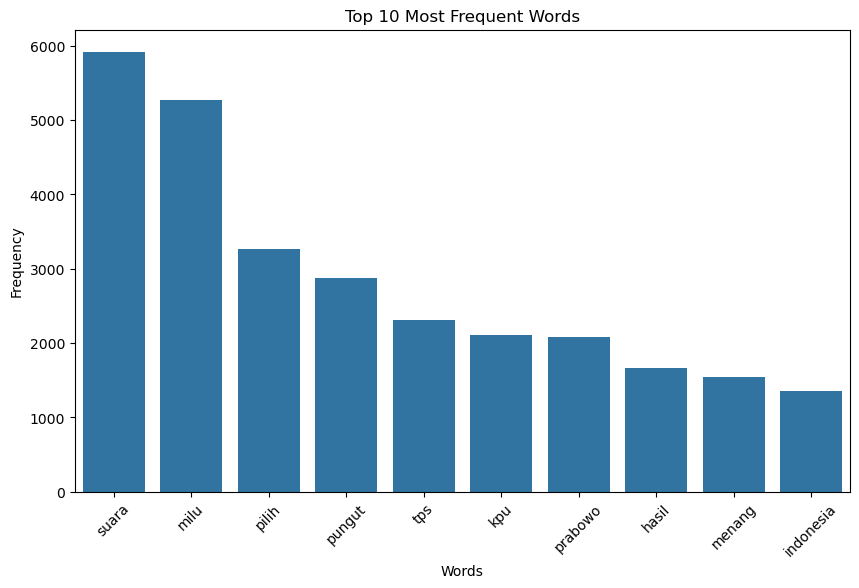

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re

# Hapus tanda baca dan ubah menjadi huruf kecil
clean_text = re.sub(r'[^\w\s]', '', all_tweets_clean.lower())

# Pecah teks menjadi daftar kata-kata
words = clean_text.split()

# Hitung frekuensi kemunculan setiap kata
word_counts = Counter(words)

# Ambil 10 kata terbanyak
top_10_words = word_counts.most_common(10)

# Konversi ke DataFrame untuk digunakan di seaborn
df_top_10 = pd.DataFrame(top_10_words, columns=['word', 'count'])

# Plot barchart menggunakan seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='word', y='count', data=df_top_10)
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Memutar label kata agar lebih mudah dibaca
plt.show()


In [47]:
data['indoBert Classification'].value_counts()

indoBert Classification
netral     7822
negatif    5705
positif    2276
Name: count, dtype: int64

## Modelling

In [48]:
X = data['full_text']
y = data['indoBert Classification']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Tfidf_vect = TfidfVectorizer(max_features=5000)
X_train_Tfidf = Tfidf_vect.fit_transform(X_train)
X_test_Tfidf = Tfidf_vect.transform(X_test)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_Tfidf, y_train)

models = {
    'Naive Bayes': naive_bayes.MultinomialNB(),
    'SVM': SVC(probability=True)
}

param_grids = {
    'Naive Bayes': {'alpha': [0.1, 0.5, 1.0]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']}
}

best_models = {}

for name, model in models.items():
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_models[name] = grid_search.best_estimator_

    y_pred = best_models[name].predict(X_test_Tfidf)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

voting_clf = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='soft'
)

voting_clf.fit(X_train_resampled, y_train_resampled)
y_pred_voting = voting_clf.predict(X_test_Tfidf)
print("\nVoting Classifier Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))


Naive Bayes Accuracy: 0.7819
              precision    recall  f1-score   support

     negatif       0.75      0.89      0.81      1741
      netral       0.92      0.75      0.82      2311
     positif       0.56      0.64      0.59       689

    accuracy                           0.78      4741
   macro avg       0.74      0.76      0.74      4741
weighted avg       0.80      0.78      0.78      4741


SVM Accuracy: 0.8180
              precision    recall  f1-score   support

     negatif       0.78      0.85      0.81      1741
      netral       0.87      0.87      0.87      2311
     positif       0.75      0.57      0.65       689

    accuracy                           0.82      4741
   macro avg       0.80      0.76      0.78      4741
weighted avg       0.82      0.82      0.82      4741


Voting Classifier Accuracy: 0.8205020037966674
              precision    recall  f1-score   support

     negatif       0.77      0.89      0.83      1741
      netral       0.89      

In [50]:
# Definisikan model
model = naive_bayes.MultinomialNB()

# Definisikan KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# List untuk menyimpan hasil akurasi setiap fold
accuracy_scores = []

# List untuk menyimpan classification report setiap fold
classification_reports = []

# Lakukan validasi silang manual
for fold, (train_index, test_index) in enumerate(kf.split(X_train_resampled)):
    # Pisahkan data ke dalam train dan test set berdasarkan fold
    X_train_fold, X_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]

    # Fit model dengan data training
    model.fit(X_train_fold, y_train_fold)

    # Prediksi data test
    y_pred = model.predict(X_test_fold)

    # Hitung accuracy
    acc = accuracy_score(y_test_fold, y_pred)
    accuracy_scores.append(acc)

    scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=10, scoring='accuracy')

    # Hitung classification report
    report = classification_report(y_test_fold, y_pred, output_dict=True)
    classification_reports.append(report)

    # Tampilkan hasil per fold
    print(f"Fold {fold + 1}:")
    print(f"Fold {fold+1}: {scores[fold]:.4f}")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test_fold, y_pred))

# Tampilkan rata-rata akurasi
print(f"\nRata-rata akurasi: {np.mean(accuracy_scores):.4f}")
print(f"\nRata-rata cross_val_acc: {scores.mean():.4f}")


Fold 1:
Fold 1: 0.7884
Accuracy: 0.8089
              precision    recall  f1-score   support

     negatif       0.74      0.89      0.81       554
      netral       0.86      0.76      0.81       553
     positif       0.84      0.77      0.81       547

    accuracy                           0.81      1654
   macro avg       0.82      0.81      0.81      1654
weighted avg       0.82      0.81      0.81      1654

Fold 2:
Fold 2: 0.7975
Accuracy: 0.8138
              precision    recall  f1-score   support

     negatif       0.74      0.90      0.81       534
      netral       0.91      0.76      0.83       570
     positif       0.82      0.79      0.80       550

    accuracy                           0.81      1654
   macro avg       0.82      0.82      0.81      1654
weighted avg       0.82      0.81      0.81      1654

Fold 3:
Fold 3: 0.8065
Accuracy: 0.8077
              precision    recall  f1-score   support

     negatif       0.76      0.91      0.82       548
      net

In [52]:
joblib.dump(best_models['Naive Bayes'], 'best_model.joblib')
joblib.dump(Tfidf_vect, 'tfidf_vectorizer.joblib')

['tfidf_vectorizer.joblib']

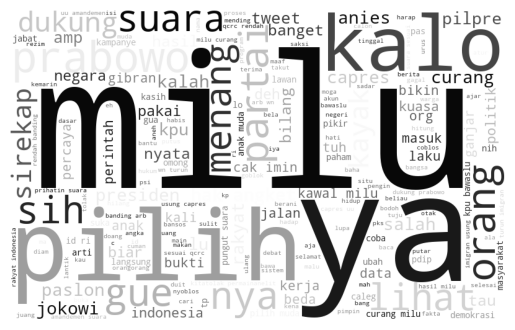

In [53]:
negative_tweets = data[data['indoBert Classification'] == 'negatif']['full_text']

# Gabungkan semua tweet negatif menjadi satu teks
all_negative_tweets = " ".join(tweet for tweet in negative_tweets)

# Buat WordCloud untuk kata-kata dari tweet dengan sentimen negatif
wc = WordCloud(background_color='white', colormap='binary',
               stopwords=['meta'], width=800, height=500).generate(all_negative_tweets)

# Tampilkan WordCloud
plt.axis("off")
plt.imshow(wc)
plt.show()


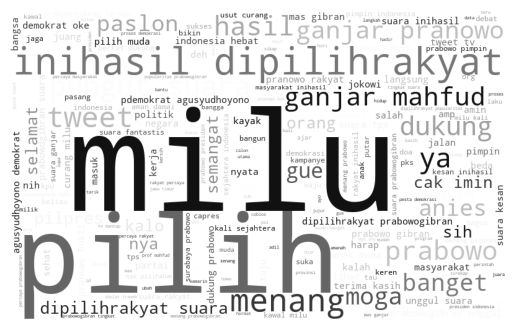

In [54]:
negative_tweets = data[data['indoBert Classification'] == 'positif']['full_text']

all_negative_tweets = " ".join(tweet for tweet in negative_tweets)

wc = WordCloud(background_color='white', colormap='binary',
               stopwords=['meta'], width=800, height=500).generate(all_negative_tweets)

plt.axis("off")
plt.imshow(wc)
plt.show()


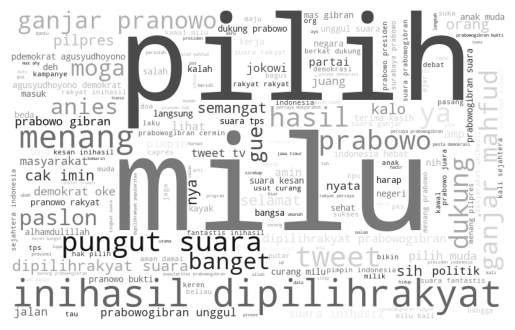

In [55]:
if data['indoBert Classification'].str.contains('netral').any():
    negative_tweets = data[data['indoBert Classification'] == 'positif']['full_text']

    all_negative_tweets = " ".join(tweet for tweet in negative_tweets)

    wc = WordCloud(background_color='white', colormap='binary',
                  stopwords=['meta'], width=800, height=500).generate(all_negative_tweets)
    plt.axis("off")
    plt.imshow(wc)
    plt.show()

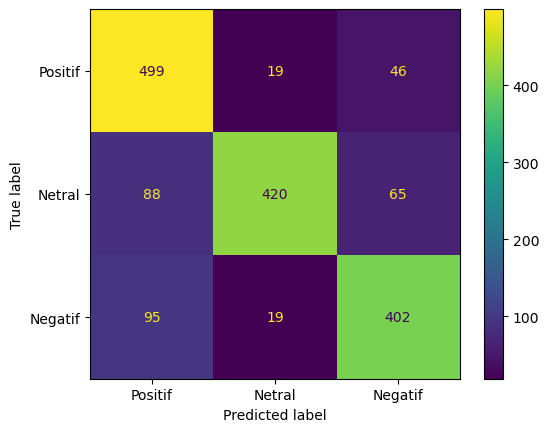

In [56]:
cm = confusion_matrix(y_test_fold, y_pred)
cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Positif', 'Netral', 'Negatif'])
cm.plot()

plt.grid(False)
plt.show()

In [57]:
end_time_code = time.time()

execution_time = end_time_code - start_time_code
print(f"Waktu eksekusi: {execution_time} detik")

Waktu eksekusi: 4320.846414089203 detik
